In [191]:
# For this notebook, we've picked an instance of maxcut. Other problems are more interesting,
# but this is the one always used in the literature.

# The goal here is to setup a Maxcut QAOA instance using qiskit, and execute it on the qiskit simulator
# using the ColdQuanta API. To validate our results, we will look for the canonical ``qaoa landscape" and 
# see that it loses contrast when the noise is increased.

In [560]:
from coldquanta.qiskit_tools.coldquanta_sim_backend import ColdQuantaSimBackend
# Set up a 2x2 grid topology.
rows = 1
cols = 2
neutral_atom = ColdQuantaSimBackend(rows=rows, cols=cols)
neutral_atom_config = neutral_atom.configuration()
coupling_map = neutral_atom_config.coupling_map

/Users/anthonypolloreno/.pyenv/versions/3.7.4/envs/qaoa_venv/lib/python3.7/site-packages/networkx/drawing/layout.py:950: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


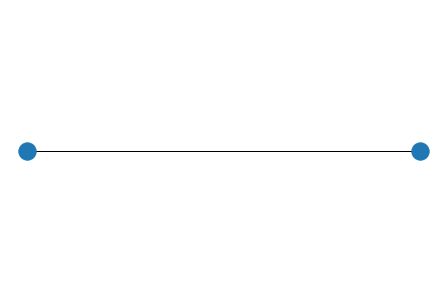

In [561]:
from networkx import Graph, draw_planar
g = Graph(coupling_map)
draw_planar(g)

In [562]:
# We will currently only accept QAOA instances on graphs isomorphic to our own -
# i.e. we are not implementing a compiler. Provide them as a dictionary.

# Uniform weights.
weights = {tuple(k): 1 for k in coupling_map}

In [647]:
# It looks like Qiskit hasn't implemented any kind of exponentiation - 
# in particular, they write to use "an Ising-type gate":
# https://qiskit.org/textbook/ch-applications/qaoa.html#2.1-(weighted)-$MAXCUT$
# Rigetti has implemented an exponentiate-like feature -
# http://docs.rigetti.com/en/stable/apidocs/autogen/pyquil.paulis.exponentiate.html#pyquil.paulis.exponentiate

# For this example, everything is diagonal and we are free to just compute the QAOA circuit from the weights.
# Taking from the qiskit tutorial:
from qiskit import QuantumCircuit
def qaoa_circuit(gamma, beta):
    QAOA = QuantumCircuit(rows*cols)
    # apply the layer of Hadamard gates to all qubits, and then fence all qubits.
    QAOA.h(range(rows*cols))
    QAOA.barrier()

    # apply the Ising type gates with angle gamma along the edges in E
    
    #HACK, we need to remove redundant edges.
    visited = set()
    for edge, weight in weights.items():
        if (min(edge), max(edge)) in visited:
            continue
        visited.add((min(edge), max(edge)))
        k = edge[0]
        l = edge[1]
        # The following is a gate decomposition for a exp(-i*\gamma*ZZ). **UNVERIFIED**.
        # Controlled-U1 gate - i.e. Controlled phase.
        QAOA.h(l)
        QAOA.cz(k, l)
        QAOA.h(l)
        QAOA.rz(2*gamma*weight, l)
        QAOA.h(l)
        QAOA.cz(k, l)
        QAOA.h(l)
        # These phases were fucking it up. In fact, we didn't want a CPHASE in the first place. 
        #QAOA.rz(-gamma*weight, k)
        #QAOA.rz(-gamma*weight, l)
        QAOA.barrier()

    # then apply the single qubit X - rotations with angle beta to all qubits

    
    #\exp^{-i\beta\sigma_x} = RX(2*\beta), so the factor of two keeps us consistent with https://arxiv.org/pdf/1411.4028 
    QAOA.rx(beta*weight, list(range(rows*cols)))
    QAOA.measure_all()
    return QAOA


In [648]:
qaoa_circuit(0,0).draw()

┌───┐ ░                                     ░ ┌───────┐ ░ ┌─┐   
   q_0: ┤ H ├─░───────■─────────────────────■───────░─┤ RX(0) ├─░─┤M├───
        ├───┤ ░ ┌───┐ │ ┌───┐┌───────┐┌───┐ │ ┌───┐ ░ ├───────┤ ░ └╥┘┌─┐
   q_1: ┤ H ├─░─┤ H ├─■─┤ H ├┤ RZ(0) ├┤ H ├─■─┤ H ├─░─┤ RX(0) ├─░──╫─┤M├
        └───┘ ░ └───┘   └───┘└───────┘└───┘   └───┘ ░ └───────┘ ░  ║ └╥┘
meas_0: ═══════════════════════════════════════════════════════════╩══╬═
                                                                      ║ 
meas_1: ══════════════════════════════════════════════════════════════╩═

In [649]:
def estimate_cost(counts, weights):
    cost = 0
    for assignment, count in counts.items():
        for edge, weight in weights.items():
            if assignment[edge[0]] != assignment[edge[1]]:
                # We've cut this edge.
                cost += weight*count
    # The coupling map currently includes both directions for all couplings. Since we've assumed an undirected
    # graph, we just divide by two.
    cost /= 2
    return cost/sum(counts.values()) 

In [650]:
import numpy as np
discretization = 15
gammas = np.linspace(0, np.pi, discretization)
betas = np.linspace(0, np.pi, discretization)

In [651]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
num_shots = 1024
experiments = []
for gamma in gammas:
    for beta in betas:
        experiments.append(qaoa_circuit(gamma, beta))
job = execute(experiments, backend=simulator, shots=num_shots)    
all_counts = job.result().get_counts()

In [652]:
landscape = np.zeros((discretization, discretization))
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        landscape[i][j] = estimate_cost(all_counts[i*len(betas) + j], weights)

0.9765625
0.01953125


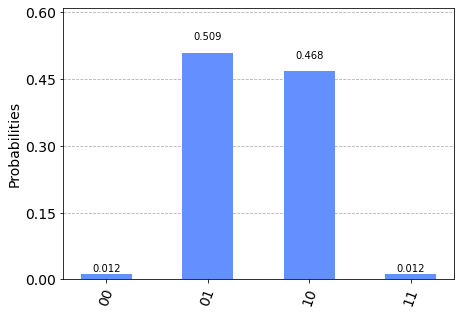

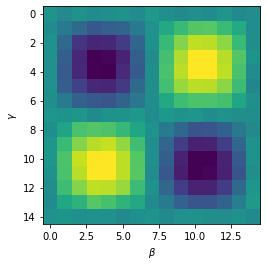

In [653]:
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

plt.imshow(landscape)
plt.ylabel(r"$\gamma$")
plt.xlabel(r"$\beta$")
print(np.max(landscape))
print(np.min(landscape))
plot_histogram(all_counts[np.argmax(landscape)])

# Now introduce noise!

In [654]:
from coldquanta.qiskit_tools.modeling.neutral_atom_noise_model import create_noise_model

In [655]:
noise_model = create_noise_model()

In [656]:
noise_model

NoiseModel:
  Basis gates: ['cx', 'cz', 'id', 'u3']
  Instructions with noise: ['rz', 'id', 'cz', 'r']
  All-qubits errors: ['r', 'rz', 'id', 'cz']

In [660]:
noise_model = create_noise_model(cz_fidelity=0.7)

experiments = []
for gamma in gammas:
    for beta in betas:
        experiments.append(qaoa_circuit(gamma, beta))
job = execute(experiments,
              simulator,
              noise_model=noise_model,
              coupling_map=coupling_map,
              optimization_level=0,
              shots=num_shots)  
all_counts = job.result().get_counts()

In [661]:
noisy_landscape = np.zeros((discretization, discretization))
for i, gamma in enumerate(gammas):
    for j, beta in enumerate(betas):
        noisy_landscape[i][j] = estimate_cost(all_counts[i*len(betas) + j], weights)

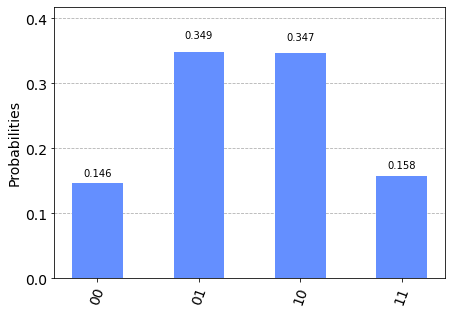

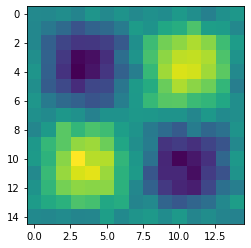

In [662]:
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

plt.imshow(noisy_landscape)
plot_histogram(all_counts[np.argmax(noisy_landscape)])